In [25]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### References
- Keras tutorial: https://keras.io/examples/vision/super_resolution_sub_pixel/
- LearnOpenCV tutorial: https://learnopencv.com/super-resolution-in-opencv/

In [26]:
def add_zoom(img, ax):
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False),plt.xticks(visible=False)
    return axins

def plot_results(img1, img2, figure_title=None):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14, 6), dpi = 200)
    plt.tight_layout() # remove white space in plot
    if figure_title is not None:
        fig.suptitle(figure_title, fontsize=22)

    ax1.imshow(img1[::-1], origin="lower"), ax1.set_title('Original', fontsize=18)
    ax2.imshow(img2[::-1], origin="lower"), ax2.set_title('High Resolution', fontsize=18)

    axins_1 = add_zoom(img1, ax1)
    axins_2 = add_zoom(img2, ax2)

    # Make the line.
    mark_inset(ax1, axins_1, loc1=1, loc2=3, fc="none", ec="blue")
    mark_inset(ax2, axins_2, loc1=1, loc2=3, fc="none", ec="blue")
    # plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

In [27]:
video_path = 'videos/Chrono Cross Cena Seguinte.mp4'

SCALE = 2

In [28]:
def start_dnn_superres(scale):
    sr = cv.dnn_superres.DnnSuperResImpl_create()
    path = "models/ESPCN_x{}.pb".format(str(scale))
    sr.readModel(path)
    sr.setModel("espcn",scale)
    return sr

def get_quality_values(orig, upsampled):
    psnr = cv.PSNR(upsampled, orig)    
    ssim = compare_ssim(upsampled, orig, multichannel=True)
    # print("PSNR: {}, SSIM: {}".format(psnr, ssim))
    return (psnr, ssim)

sr = start_dnn_superres(SCALE)
video_h, video_w = 600, 800

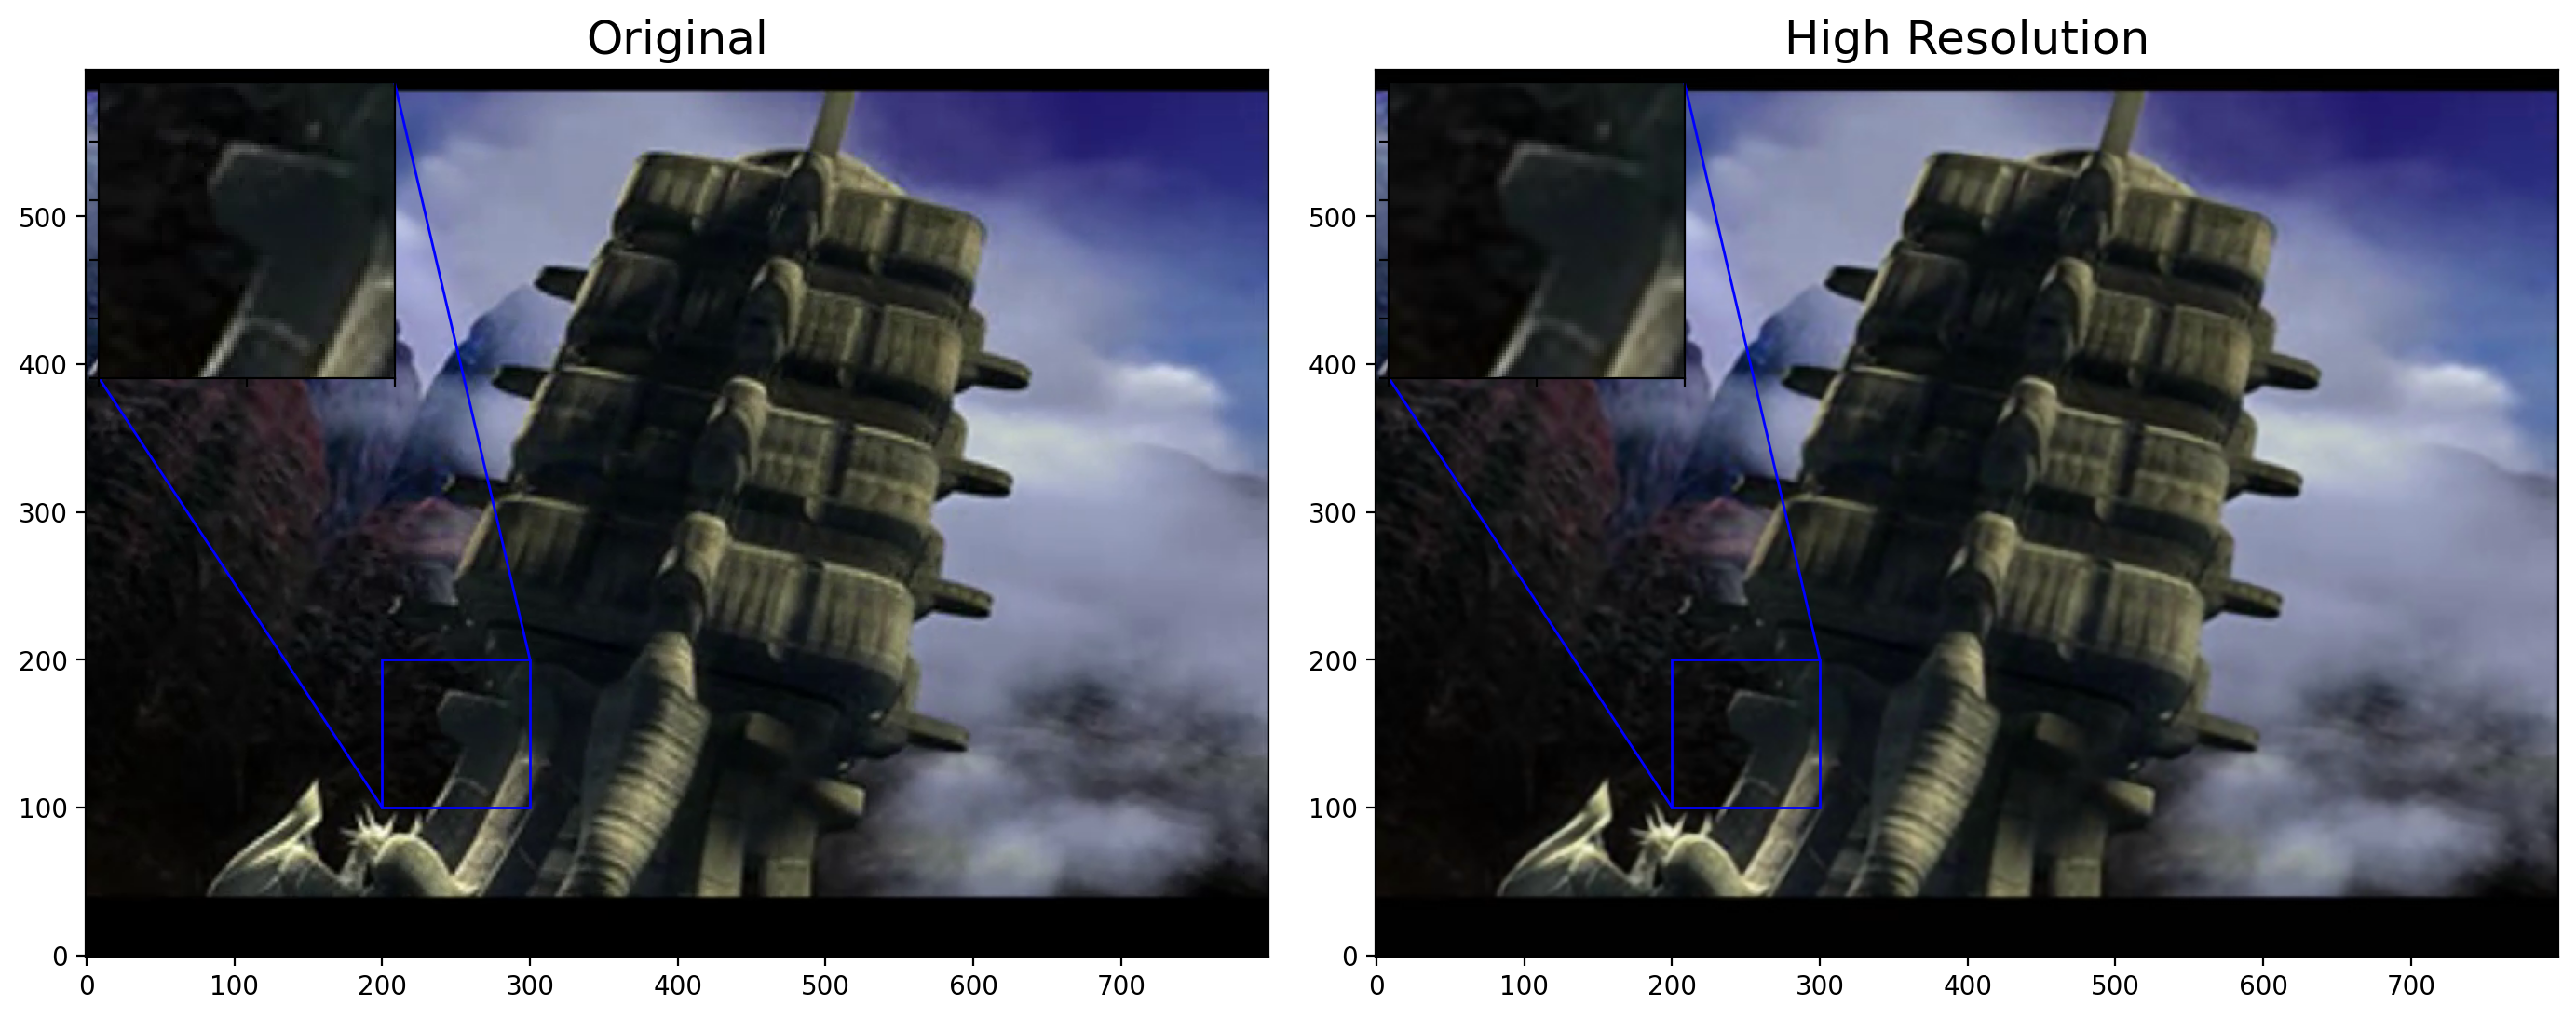

Can't read frame
Avg. PSNR of low resolution images is 36.8065
Avg. PSNR of reconstructions is 39.1579
Avg. SSIM of low resolution images is 0.9750
Avg. SSIM of reconstructions is 0.9753


In [29]:
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print("Cannot open video")
    exit()

total_bicubic_psnr, total_test_psnr = 0.0, 0.0
total_bicubic_ssim, total_test_ssim = 0.0, 0.0
number_of_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
i = 0
# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'XVID')
write_video = cv.VideoWriter('prediction.avi', fourcc, 20.0, (video_h,  video_w))

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        print("Can't read frame")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

    lowres_input = cv.resize(frame, None, fx=1.0/SCALE, fy=1.0/SCALE, interpolation=cv.INTER_AREA) # scale 2 = reduce img to (300, 400, 3)
    w = lowres_input.shape[1] * SCALE
    h = lowres_input.shape[0] * SCALE
    highres_img = frame
    prediction = sr.upsample(lowres_input)
    lowres_img = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)

    bicubic_psnr, bicubic_ssim = get_quality_values(lowres_img, highres_img)
    test_psnr, test_ssim = get_quality_values(prediction, highres_img)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr
    total_bicubic_ssim += bicubic_ssim
    total_test_ssim += test_ssim

    # plot frame 500
    if i == 500:
        plot_results(frame, prediction)
    i += 1
    # plot_results(frame, prediction)

    # print(i, end=', ')
    write_video.write(prediction)
    # break

capture.release()
write_video.release() # BUG video is not correctly saved
cv.destroyAllWindows()

print("Avg. PSNR of low resolution images is {:.4f}".format((total_bicubic_psnr / number_of_frames)))
print("Avg. PSNR of reconstructions is {:.4f}".format((total_test_psnr / number_of_frames)))
print("Avg. SSIM of low resolution images is {:.4f}".format((total_bicubic_ssim / number_of_frames)))
print("Avg. SSIM of reconstructions is {:.4f}".format((total_test_ssim / number_of_frames)))

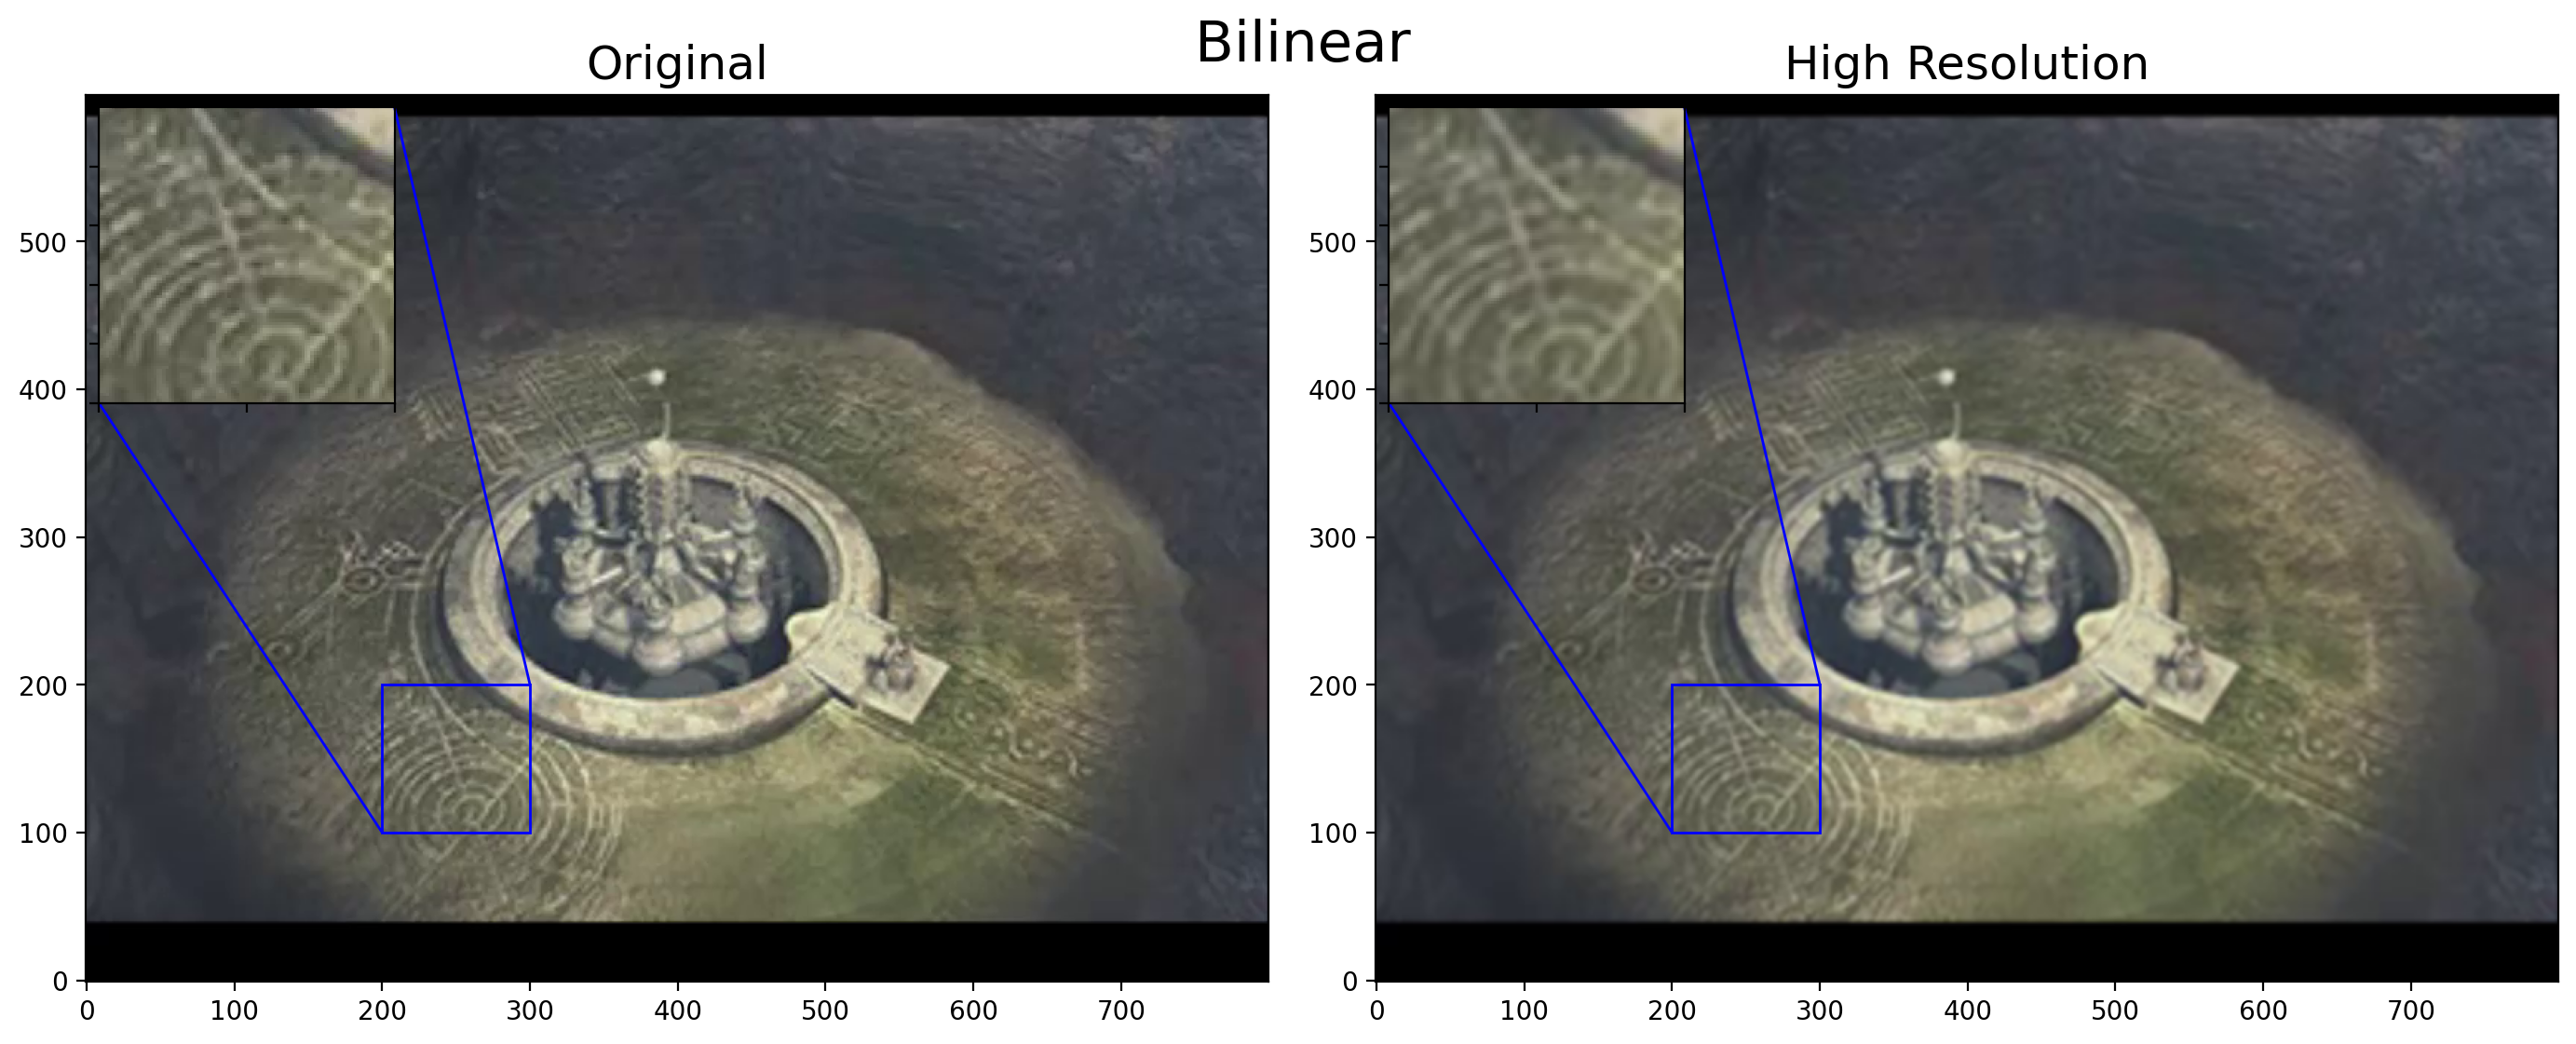

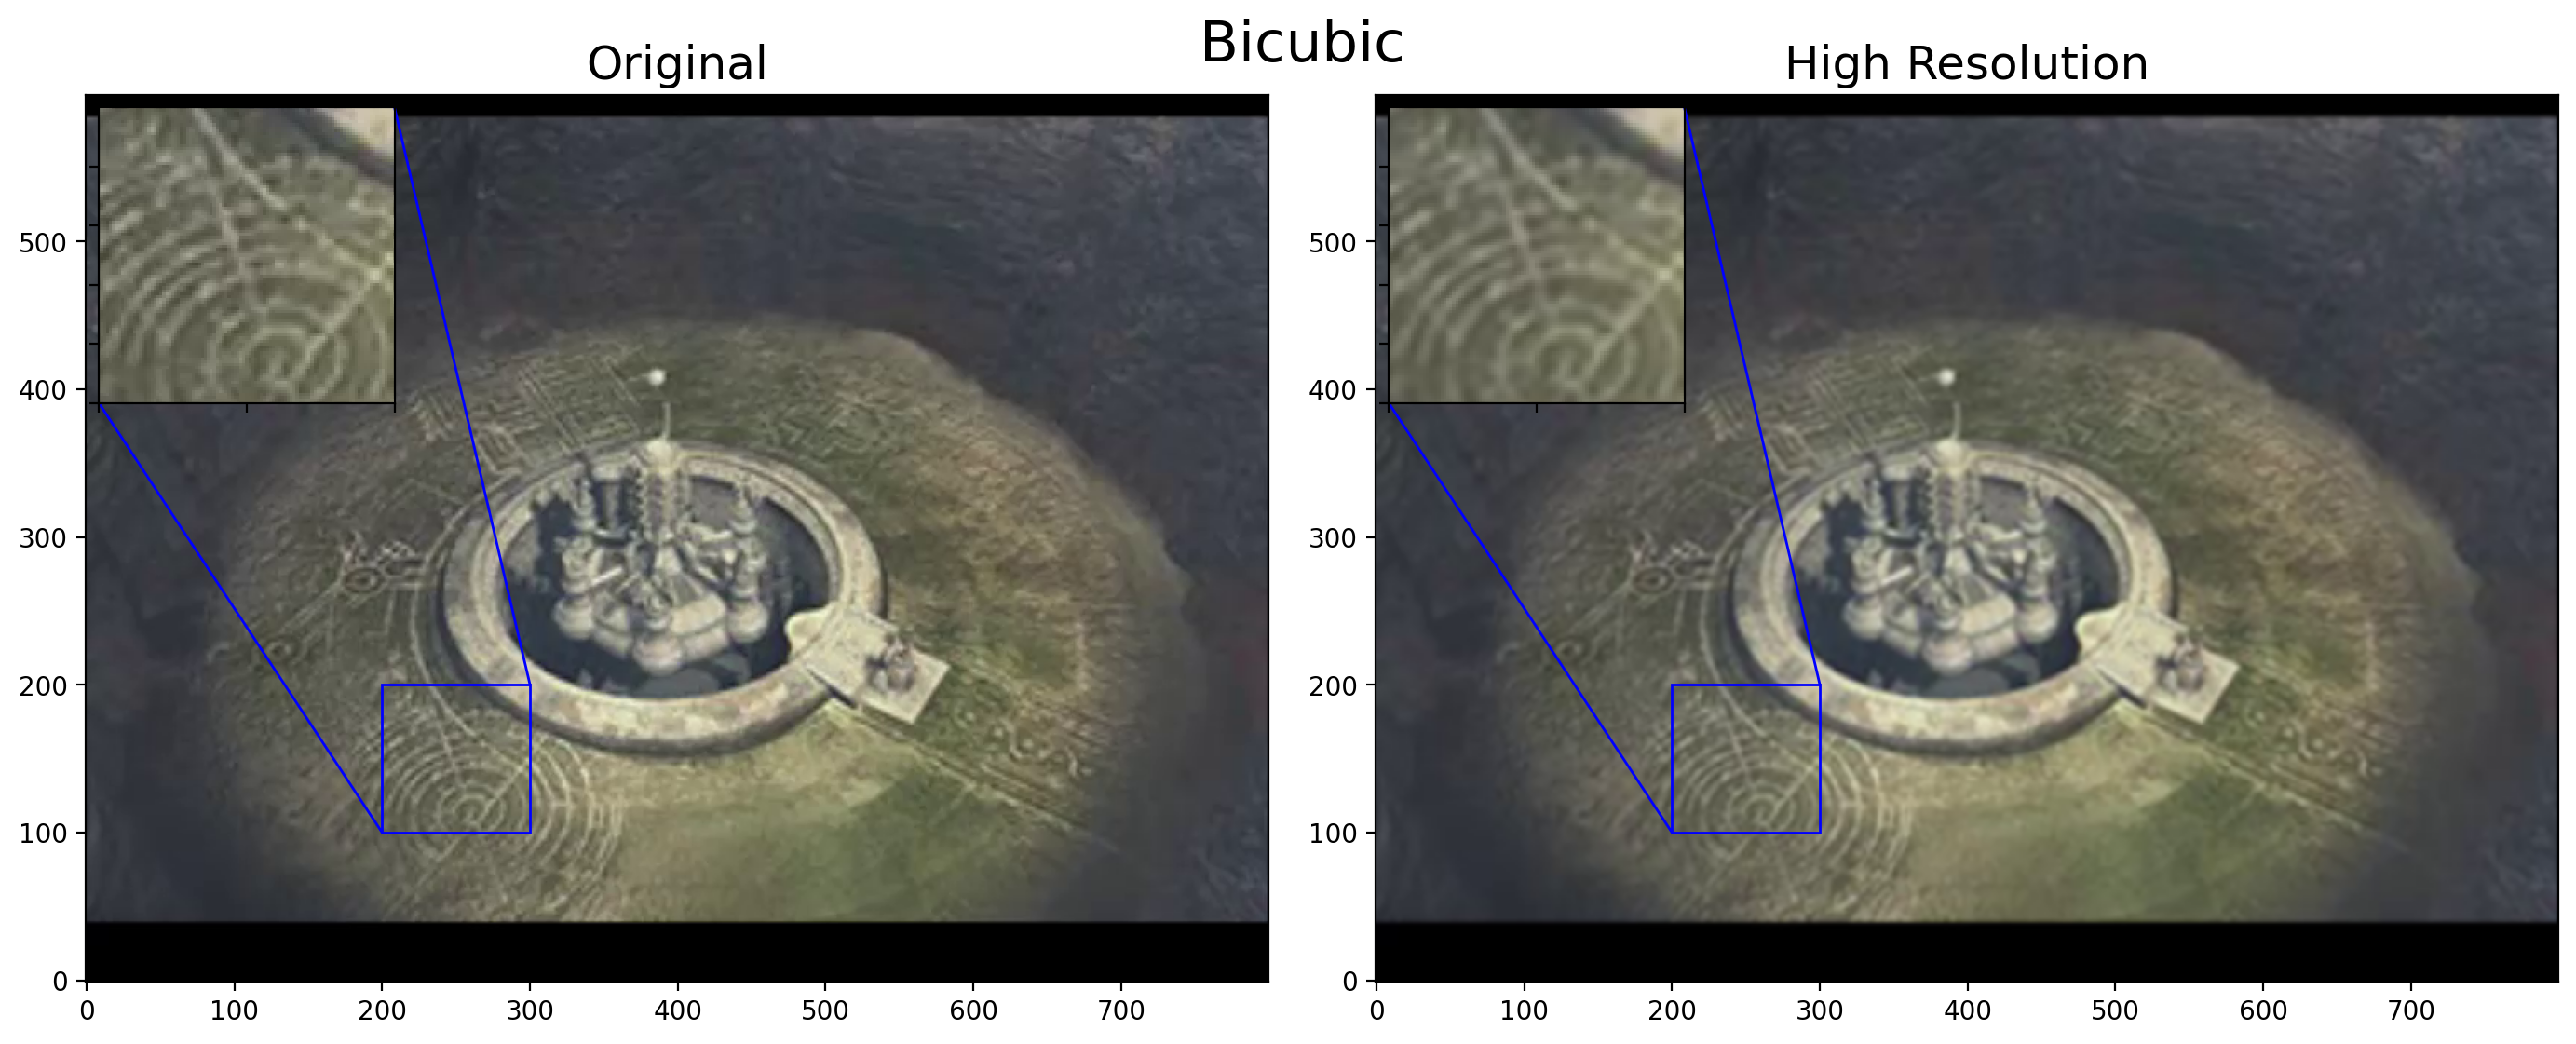

Avg. PSNR of Bilinear is 40.1209
Avg. PSNR of Bicubic is 40.1209
Avg. SSIM of Bilinear is 0.9762
Avg. SSIM of Bicubic is 0.9762


In [24]:
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print("Cannot open video")
    exit()

total_bicubic_psnr, total_bilinear_psnr = 0.0, 0.0
total_bicubic_ssim, total_bilinear_ssim = 0.0, 0.0
number_of_frames = int(capture.get(cv.CAP_PROP_FRAME_COUNT))
i = 0
# Define the codec and create VideoWriter object
# fourcc = cv.VideoWriter_fourcc(*'XVID')
# write_video = cv.VideoWriter('prediction.avi', fourcc, 20.0, (video_h,  video_w))

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        print("Can't read frame")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

    lowres_input = cv.resize(frame, None, fx=1.0/SCALE, fy=1.0/SCALE, interpolation=cv.INTER_AREA) # scale 2 = reduce img to (300, 400, 3)
    w = lowres_input.shape[1] * SCALE
    h = lowres_input.shape[0] * SCALE
    highres_img = frame

    lowres_img_bilinear = cv.resize(lowres_input, (w, h), cv.INTER_LINEAR) # scale 2 = (600, 800, 3)
    lowres_img_bicubic = cv.resize(lowres_input, (w, h), cv.INTER_CUBIC) # scale 2 = (600, 800, 3)

    bilinear_psnr, bilinear_ssim = get_quality_values(lowres_img_bilinear, highres_img)
    bicubic_psnr, bicubic_ssim = get_quality_values(lowres_img_bicubic, highres_img)

    total_bicubic_psnr += bicubic_psnr
    total_bilinear_psnr += bilinear_psnr
    total_bicubic_ssim += bicubic_ssim
    total_bilinear_ssim += bilinear_ssim

    # Plot only first frame
    i += 1
    plot_results(frame, lowres_img_bilinear, 'Bilinear') # bilinear
    plot_results(frame, lowres_img_bicubic, 'Bicubic') # bicubic

    break

capture.release()
# write_video.release()
cv.destroyAllWindows()

print("Avg. PSNR of Bilinear is {:.4f}".format((total_bicubic_psnr / 1)))
print("Avg. PSNR of Bicubic is {:.4f}".format((total_bilinear_psnr / 1)))
print("Avg. SSIM of Bilinear is {:.4f}".format((total_bicubic_ssim / 1)))
print("Avg. SSIM of Bicubic is {:.4f}".format((total_bilinear_ssim / 1)))